In [69]:
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
sys.path.insert(0, 'bin')
%load_ext autoreload
%autoreload 2
#from data_loader import DataLoader
from data_agg import DataAggregator
#from check_pipeline import load_data

# Описание датасета

Имеется датасет, разделённый на файлы

In [3]:
!ls data/train_data/

train_data_0.pq   train_data_1.pq  train_data_4.pq  train_data_7.pq
train_data_10.pq  train_data_2.pq  train_data_5.pq  train_data_8.pq
train_data_11.pq  train_data_3.pq  train_data_6.pq  train_data_9.pq


Всего 12 файлов. Отложим первые три в качестве тестовых данных, а остальные используем для обучения

In [4]:
descr = pd.read_csv('description.csv')
N = 24 # кол-во месяцев минус 1 в enc_paym: от enc_paym_0 до enc_paym_24
print(f'Всего {descr.shape[0]} + {N} = {descr.shape[0] + N}  полей:\n')
for f, d in descr.values:
    print(f'{f:30s} {d}')

Всего 37 + 24 = 61  полей:

id                             Идентификатор заявки. Заявки пронумерованы так, что большему номеру соответствует более поздняя дата заявки.
rn                             Порядковый номер кредитного продукта в кредитной истории. Большему номеру соответствует продукт с более поздней датой открытия.
pre_since_opened               Дней с даты открытия кредита до даты сбора данных (бинаризовано*)
pre_since_confirmed            Дней с даты подтверждения информации по кредиту до даты сбора данных (бинаризовано*)
pre_pterm                      Плановое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
pre_fterm                      Фактическое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
pre_till_pclose                Плановое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
pre_till_fclose                Фактическое количество дней с даты сбора данных до даты закрытия кредита (бинаризов

\* область значений поля разбивается на N непересекающихся промежутков, каждому промежутку случайным образом ставится в соответствие уникальный номер от 0 до N-1, значение поля заменяется номером промежутка, которому оно принадлежит (это называется *квантовано*, а не бинаризировано)

** каждому уникальному значению поля случайным образом ставится в соответствие уникальный номер от 0 до K, значение поля заменяется номером этого значения

Хотя датасет представлен таблицей (2-мерным массивом), он по факту является 3-мерным массивом с динамическим размером второй оси. Первая ось соответствует `id`, т.е. отдельному человеку. Вторая — `rn`  — номеру взятого кредита. Третья ось — признаки для конкретного кредита.

Для обучения модели, необходимо превратить данные в настоящий 2-мерный массив, аггрегируя по второй оси. Для того, чтобы не слишком много информации потерять при этом, можно использовать разные функции аггригирования для одних и тех же признаков, а так же добавить новые признаки до аггрегирования.

# План работы

 - Сначала загрузим датасет, проанализируем его структуру и значения признаков
 - Затем сконструируем новые признаки
 - Аггрегируем данные
 - Подберём модели и гиперпараметры
 - Обучим модель на 9 файлах (3–11) из 12 и соберём pipeline
 - Проверим паёплайн на 3 осташехся файлах (0, 1, 2)

# Загрузка датасета

In [5]:
df = pd.read_parquet('data/train_data/train_data_3.pq')
df.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,750000,1,10,11,11,13,16,12,14,2,3,0,2,2,6,16,5,4,8,1,0,1,1,1,9,5,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,3,3,1,0,0
1,750000,2,0,2,8,8,6,11,5,2,3,0,3,2,6,16,5,4,8,1,1,1,1,0,16,2,17,0,0,0,3,0,0,0,0,0,0,0,0,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,4,1,0,1
2,750000,3,17,13,12,10,2,6,11,2,3,0,2,2,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,3,3,4,1,3,4,1,0,0
3,750000,4,3,16,17,16,12,11,2,5,1,0,2,11,6,0,5,4,8,1,0,1,1,1,2,2,17,0,1,1,0,1,1,1,0,0,1,1,1,1,1,2,1,1,0,1,1,0,0,1,1,0,0,0,4,1,2,2,1,0,0
4,750000,5,11,16,17,8,8,11,12,2,4,0,2,1,6,16,5,4,8,1,1,1,1,1,3,2,17,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,3,3,3,4,1,2,3,1,0,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112592 entries, 0 to 2112591
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

Сохраним названия колонок в отдельный датасет

In [7]:
cols = df.columns
pd.DataFrame(cols).to_csv('data/colunms.csv', index=None, header=None)
pd.DataFrame(cols).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag


# Значения

In [8]:
id_unique = df['id'].unique()
id_unique

array([750000, 750001, 750002, ..., 999997, 999998, 999999])

In [9]:
df['rn'].value_counts()

rn
1     250000
2     231437
3     212210
4     192430
5     172704
6     153773
7     135652
8     118844
9     103525
10     89721
11     77268
12     66115
13     56376
14     48103
15     40781
16     34099
17     28241
18     23087
19     18614
20     14703
21     11492
22      8817
23      6623
24      4823
25      3620
26      2619
27      1910
28      1404
29      1029
30       727
31       542
32       392
33       279
34       192
35       139
36        97
37        64
38        48
39        31
40        22
41        14
42        11
43         6
44         2
45         1
46         1
47         1
48         1
49         1
50         1
Name: count, dtype: int64

In [10]:
for col in cols:
    if col != 'id':
        assert (0 <= df[col]).all()
        assert (df[col] < 128).all()

60 * 127, 2**15 - 1

(7620, 32767)

Значения `rn` лежат от 1 до 58

Все значения кроме `id` лежат в пределах от 0 до 127

При аггрегированния максимум получится 60 * 127 = 7366 < 2**15 - 1

Поэтому всё кроме `id` можно сохраниить в типе `int16` для экономии памяти

In [11]:
convert_dict = {col: 'int16' for col in cols if col != 'id'}
df = df.astype(convert_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112592 entries, 0 to 2112591
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int16
 2   pre_since_opened               int16
 3   pre_since_confirmed            int16
 4   pre_pterm                      int16
 5   pre_fterm                      int16
 6   pre_till_pclose                int16
 7   pre_till_fclose                int16
 8   pre_loans_credit_limit         int16
 9   pre_loans_next_pay_summ        int16
 10  pre_loans_outstanding          int16
 11  pre_loans_total_overdue        int16
 12  pre_loans_max_overdue_sum      int16
 13  pre_loans_credit_cost_rate     int16
 14  pre_loans5                     int16
 15  pre_loans530                   int16
 16  pre_loans3060                  int16
 17  pre_loans6090                  int16
 18  pre_loans90                    int16
 19  

Было 1.1 GB. Стало 300 MB.

# Сравним с другими датасетами

Проверим следующие утверждения:
 - Все датасеты имеют одинаковые колонки в одинаковом порядке
 - Нет значений Nan
 - В каждом файле ровно 250_000 id-в, а именно от 250_000 * i до 250_000 * (i+1) - 1
 - Значения `rn` лежат от 1 до 58
 - Все значения кроме `id` лежат в пределах от 0 до 127.

Посчитаем количество строк

In [12]:
def check_data(i):
    df = pd.read_parquet(f'data/train_data/train_data_{i}.pq')
    assert (cols == df.columns).all()
    assert not df.isnull().any().any()
    assert (df['id'].unique() == np.arange(250_000 * i, 250_000 * (i+1))).all()
    assert (df['rn'] < 59).all()
    for col in cols:
        if col != 'id':
            assert (0 <= df[col]).all()
            assert (df[col] < 128).all()
    print(f'{i}: {df.shape[0]:_}', df.shape[1])

for i in range(12):
    check_data(i)

print('Всё верно')

0: 1_974_724 61
1: 2_107_305 61
2: 2_080_508 61
3: 2_112_592 61
4: 2_064_110 61
5: 2_150_908 61
6: 2_176_452 61
7: 2_222_245 61
8: 2_242_615 61
9: 2_284_256 61
10: 2_296_372 61
11: 2_450_630 61
Всё верно


Размеры данных:

0: 1_974_724

1: 2_107_305

2: 2_080_508

3: 2_112_592

4: 2_064_110

5: 2_150_908

6: 2_176_452

7: 2_222_245

8: 2_242_615

9: 2_284_256

10: 2_296_372

11: 2_450_630

# Колонки enc_paym и новые фичи

In [14]:
enc_paym_cols = [col for col in cols if col.startswith('enc_paym')]
enc_paym_cols

['enc_paym_0',
 'enc_paym_1',
 'enc_paym_2',
 'enc_paym_3',
 'enc_paym_4',
 'enc_paym_5',
 'enc_paym_6',
 'enc_paym_7',
 'enc_paym_8',
 'enc_paym_9',
 'enc_paym_10',
 'enc_paym_11',
 'enc_paym_12',
 'enc_paym_13',
 'enc_paym_14',
 'enc_paym_15',
 'enc_paym_16',
 'enc_paym_17',
 'enc_paym_18',
 'enc_paym_19',
 'enc_paym_20',
 'enc_paym_21',
 'enc_paym_22',
 'enc_paym_23',
 'enc_paym_24']

In [15]:
for col in enc_paym_cols:
    print(col, df[col].max())

enc_paym_0 3
enc_paym_1 3
enc_paym_2 3
enc_paym_3 3
enc_paym_4 3
enc_paym_5 3
enc_paym_6 3
enc_paym_7 3
enc_paym_8 3
enc_paym_9 3
enc_paym_10 3
enc_paym_11 4
enc_paym_12 3
enc_paym_13 3
enc_paym_14 3
enc_paym_15 3
enc_paym_16 3
enc_paym_17 3
enc_paym_18 3
enc_paym_19 3
enc_paym_20 4
enc_paym_21 3
enc_paym_22 3
enc_paym_23 3
enc_paym_24 4


Максимальное значение 4 в колонках 11, 20, 24. В остальных — 3.

In [16]:
enc_table = np.zeros([5, len(enc_paym_cols)], dtype=np.uint8)
for j, col in enumerate(enc_paym_cols):
    s = df[col].value_counts()
    for i in s.index:
        enc_table[i, j] = s[i]
pd.DataFrame(enc_table, index=range(5), columns=enc_paym_cols)

,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24
0,118,128,184,230,206,227,207,231,42,73,40,0,151,16,202,13,155,91,176,194,0,79,230,38,0
1,253,168,34,131,212,163,250,8,109,166,208,160,163,71,160,121,17,61,62,28,127,252,44,37,85
2,144,2,116,154,28,95,175,83,253,2,224,157,132,8,198,12,121,4,232,221,107,117,149,250,90
3,77,38,2,77,146,107,216,14,188,95,120,241,146,241,32,190,43,180,122,149,57,144,169,11,37
4,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,45,0,0,0,124


Мы видим, что в в колонках 11, 20, 24 значения сдвинуты на единицу.

In [17]:
enc_shifted_cols = [enc_paym_cols[i] for i in [11, 20, 24]]
enc_shifted_cols

['enc_paym_11', 'enc_paym_20', 'enc_paym_24']

Сдвиним значенияв этих колонках, чтобы получить однообразную кодировку.

In [18]:
df_prepared = df.copy()
df_prepared[enc_shifted_cols] = df_prepared[enc_shifted_cols].apply(lambda i: i -1, axis=1)

In [19]:
(df_prepared[enc_paym_cols] < 4).all(None)

True

Посмотрим на значения

In [20]:
df_prepared[enc_paym_cols].head(140).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139
enc_paym_0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
enc_paym_1,1,0,0,1,0,0,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,3,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
enc_paym_2,0,0,0,1,0,0,3,3,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,3,1,0,0,0,0,0,0,0,0,0,3,0,0,3,3,0,0,0,0,0,0,0,0,1,0
enc_paym_3,0,0,0,1,0,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,3,0,0,3,3,3,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,1,0,1,0,0,0,0,3,0,0,0,3,0,0,0,3,0,0,0,0,0,0,3,0,3,3,3,0,0,0,0,0,0,0,0,1,0
enc_paym_4,0,0,0,0,0,3,3,3,3,3,3,3,3,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,3,0,0,3,3,3,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,3,3,3,0,0,3,3,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,3,0,0,0,0,0,0,3,0,3,3,3,0,0,0,0,0,0,0,0,0,0
enc_paym_5,0,0,0,0,0,3,3,3,3,3,3,3,3,3,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,3,0,0,3,3,3,3,0,0,3,0,0,0,0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,3,1,3,0,0,0,0,0,0,0,3,3,3,0,0,3,3,0,0,0,0,0,0,0,3,0,0,1,2,0,0,0,3,3,0,0,0,1,0,3,0,3,3,3,0,0,0,0,0,0,0,0,0,0
enc_paym_6,0,0,0,1,0,3,3,3,3,3,3,3,3,3,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,1,3,0,0,3,3,3,3,0,0,3,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,3,0,0,0,0,0,3,3,0,0,0,0,0,3,0,3,0,0,3,0,0,0,0,3,3,3,0,0,3,3,0,0,3,0,0,0,0,3,0,0,0,3,0,0,0,3,3,0,0,0,0,0,3,0,3,3,3,0,0,3,0,0,3,0,0,1,3
enc_paym_7,0,0,0,1,0,3,3,3,3,3,3,3,3,3,0,0,0,1,3,3,3,3,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,3,0,0,3,3,3,3,3,0,3,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,3,0,0,0,0,0,3,3,0,0,0,0,0,3,0,3,0,0,3,0,3,3,3,3,3,3,0,0,3,3,0,0,3,0,0,0,0,3,0,0,0,3,0,0,0,3,3,0,0,0,0,0,3,0,3,3,3,0,0,3,0,0,3,1,0,0,3
enc_paym_8,0,0,0,1,0,3,3,3,3,3,3,3,3,3,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,3,3,3,3,3,0,1,3,3,0,3,3,3,3,3,0,3,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,3,0,0,0,0,0,3,3,0,0,0,0,0,3,0,3,1,0,3,0,3,3,3,3,3,3,0,0,3,3,0,0,3,0,0,0,0,3,0,1,1,3,0,0,0,3,3,0,0,0,0,0,3,0,3,3,3,0,3,3,0,3,3,0,0,1,3
enc_paym_9,0,3,0,1,0,3,3,3,3,3,3,3,3,3,0,0,0,1,3,3,3,3,0,0,0,0,0,0,0,0,0,3,3,3,3,3,0,1,3,3,0,3,3,3,3,3,0,3,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,3,1,0,3,0,3,0,0,0,0,0,3,3,0,0,0,0,0,3,0,3,0,0,3,0,3,3,3,3,3,3,0,0,3,3,0,0,3,0,0,0,0,3,0,0,0,3,0,0,0,3,3,1,0,1,0,0,3,3,3,3,3,0,3,3,0,3,3,0,0,1,3


В основном нули и тройки.

Посмотрим специально туда, где есть хотя бы одна единицка или двойка

In [21]:
df2 = df_prepared[enc_paym_cols]
df2[(df2 == 1).any(axis=1)].head(140).T

,0,3,10,16,17,37,43,56,60,61,62,65,66,67,68,69,81,84,87,89,90,91,103,105,106,108,109,112,113,115,120,122,123,127,136,138,141,142,148,149,185,186,188,191,198,214,215,216,217,218,219,220,221,223,224,241,245,254,255,262,263,268,288,290,291,316,317,319,320,321,322,323,325,393,401,406,410,411,414,416,417,419,426,433,445,449,455,456,458,459,464,465,475,476,483,485,488,490,493,494,495,496,498,502,504,505,508,514,522,523,534,540,551,552,558,559,563,564,571,578,580,581,582,583,584,593,596,600,601,603,605,608,610,611,612,614,616,618,625,626
enc_paym_0,0,0,1,0,0,0,3,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,2,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
enc_paym_1,1,1,3,0,0,1,3,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,3,0,0,0,1,1,1,0,0,0,0,0,3,0,1,3,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,3,0,0,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0
enc_paym_2,0,1,3,0,0,0,3,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,1,0,0,1,0,0,0,2,0,0,3,0,1,1,0,0,1,1,0,1,1,3,1,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,1,1,0,0,0,3,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0
enc_paym_3,0,1,3,0,0,1,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,3,0,1,1,0,1,0,0,0,3,0,0,0,0,3,1,1,1,1,0,1,1,0,0,3,0,0,1,0,1,0,1,0,0,0,3,0,0,0,0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,1,0,0,1,0,3,0,0,0,1,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
enc_paym_4,0,0,3,0,1,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,3,0,0,0,0,2,0,1,1,0,0,1,0,0,0,3,0,0,1,1,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,3,0,0,3,0,0,0,0,0,2,1,1,1,2,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0
enc_paym_5,0,0,3,0,0,0,3,0,0,0,1,0,0,0,3,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3,0,0,2,0,1,1,0,0,3,0,0,1,3,1,0,3,3,0,1,0,0,1,0,3,0,0,1,1,0,1,1,0,0,0,3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1,1,3,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,3,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0
enc_paym_6,0,1,3,0,0,1,3,0,0,0,0,0,1,0,3,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,3,0,1,1,0,1,0,0,0,1,0,0,0,3,1,0,3,3,0,0,1,0,3,0,3,0,0,3,1,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,3,1,0,3,0,0,0,1,1,0,1,1,3,0,0,0,1,0,0,0,1,0,0,1,0,0,0,3,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,3,0
enc_paym_7,0,1,3,0,1,0,3,0,0,0,0,0,3,0,3,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,0,0,3,1,3,0,3,0,0,3,0,0,0,1,0,0,0,3,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,3,1,0,3,1,0,0,0,0,3,1,3,3,3,1,1,1,1,0,0,1,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,3,0
enc_paym_8,0,1,3,0,0,1,3,0,0,0,0,0,3,0,3,0,0,0,0,1,0,3,0,3,0,0,0,1,1,0,0,0,0,3,0,1,1,0,1,0,0,0,0,3,0,0,3,3,1,3,3,1,0,3,0,3,0,3,0,0,3,0,0,1,1,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,3,0,0,0,0,1,3,1,3,3,3,1,3,1,1,0,1,1,3,0,0,1,1,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,3,0
enc_paym_9,0,1,3,0,1,1,3,0,0,0,0,0,3,0,3,1,0,0,0,0,0,3,0,3,0,0,0,0,0,0,1,1,0,3,0,1,0,0,0,1,0,0,0,3,0,0,3,3,1,3,3,1,0,3,0,3,0,3,0,0,3,0,0,0,1,0,0,0,3,0,0,3,0,0,3,0,1,1,0,0,0,0,0,0,3,3,0,3,0,0,0,0,1,3,1,3,3,3,0,3,1,1,1,0,1,3,0,0,1,1,0,0,0,0,3,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0


In [22]:
df2[(df2 == 2).any(axis=1)].head(140).T

,17,43,114,141,215,216,224,254,320,419,456,476,498,508,521,580,581,583,584,627,658,671,674,706,715,723,805,816,833,866,868,941,979,983,985,1036,1073,1134,1135,1136,1140,1157,1158,1160,1166,1170,1183,1195,1285,1289,1291,1298,1299,1302,1328,1439,1442,1509,1524,1576,1588,1604,1658,1669,1686,1692,1694,1697,1730,1734,1735,1736,1788,1834,1872,1935,1952,1994,2015,2053,2073,2116,2117,2118,2119,2144,2170,2213,2214,2216,2228,2232,2247,2266,2288,2339,2376,2455,2461,2474,2575,2589,2605,2616,2678,2750,2752,2790,2819,2891,2893,2894,2956,2957,2958,3035,3070,3071,3100,3132,3133,3137,3185,3186,3187,3190,3227,3270,3271,3282,3394,3434,3474,3513,3514,3592,3608,3610,3612,3613
enc_paym_0,0,3,3,0,2,1,0,3,3,0,0,0,0,0,0,3,0,0,0,1,0,0,3,0,0,2,0,0,0,0,2,0,0,0,0,0,3,0,1,0,0,0,3,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,3,0,2,2,2,0,0,0,3,0,0,2,1,0,2,0,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,2,0,0,2,0,0,3,0,1,0,0,2,0,3,3,0,0,1,0,0,0,0,0,3,2,3,0,0,0,1,2,1,0,1,3,0,2,0,2,3,0,0,1,0,0,0,0
enc_paym_1,0,3,3,0,1,1,3,3,3,0,2,0,0,0,3,3,0,1,0,0,1,0,2,2,0,1,0,3,3,1,2,0,0,0,0,2,3,2,1,0,1,0,3,3,2,0,0,0,0,0,0,0,0,2,1,0,0,2,2,0,3,3,0,1,1,1,3,0,2,3,3,3,1,1,0,1,3,3,2,0,0,3,0,1,3,2,3,1,0,0,0,0,0,1,2,0,3,0,2,3,0,1,1,0,1,0,3,3,0,0,0,0,0,0,1,0,3,2,3,0,0,1,1,1,1,1,2,3,0,1,2,0,3,2,1,1,0,3,1,1
enc_paym_2,0,3,3,0,0,1,2,3,3,3,1,3,1,1,3,0,0,1,0,0,2,0,1,1,3,1,0,3,3,1,1,0,0,0,0,1,3,1,2,1,0,1,3,3,1,0,3,0,0,0,0,0,1,1,2,2,0,1,1,0,3,3,0,1,1,1,3,0,1,3,3,3,0,1,0,0,3,2,1,0,1,3,0,1,3,1,3,0,1,0,0,0,0,1,1,3,3,0,2,3,0,1,2,0,0,1,3,3,0,0,1,0,0,0,0,0,2,1,2,0,3,0,2,1,1,0,1,3,0,1,1,0,3,1,1,0,0,3,0,0
enc_paym_3,0,3,3,1,0,3,1,3,3,2,1,3,0,2,3,0,0,2,0,0,1,3,1,1,2,0,0,3,3,1,2,0,0,1,0,0,3,1,2,0,0,1,3,3,0,3,3,0,3,3,1,0,0,1,1,2,3,0,1,0,3,3,0,0,1,1,3,2,0,3,3,3,0,1,0,1,3,1,0,0,1,3,2,1,3,0,3,2,0,0,0,0,0,1,0,3,2,0,1,3,0,2,1,0,3,1,3,3,0,3,2,2,0,1,1,0,1,0,3,3,3,0,2,1,1,1,1,3,0,0,0,0,3,0,1,0,0,2,0,1
enc_paym_4,1,3,3,0,0,2,0,3,3,1,0,3,2,2,3,0,0,1,0,0,1,2,1,3,1,0,0,3,3,3,2,0,0,1,0,0,3,0,1,0,0,1,3,3,0,3,2,0,3,3,1,0,0,1,1,1,3,2,1,0,3,3,0,0,1,0,3,1,0,3,3,3,0,1,0,1,3,2,0,0,1,2,0,1,3,0,3,2,0,0,1,2,0,0,0,3,1,1,0,3,0,1,0,0,3,0,2,3,0,3,1,1,0,3,1,0,0,3,3,2,2,0,1,1,0,0,0,3,0,0,0,0,3,1,0,0,0,1,0,2
enc_paym_5,0,3,2,2,3,1,0,3,3,0,0,3,0,0,3,3,0,1,0,0,0,0,1,3,0,0,2,3,3,2,1,3,0,0,0,1,3,0,0,0,0,1,3,3,3,3,1,0,2,3,1,0,0,0,0,1,3,1,0,0,3,3,0,1,0,1,2,1,2,3,3,3,0,1,0,1,3,2,0,1,0,1,0,0,3,0,3,1,1,0,0,1,2,3,0,2,0,0,0,3,1,0,1,0,3,0,1,3,0,3,1,1,0,3,1,0,3,3,3,1,1,0,1,1,1,1,0,3,0,0,0,0,3,0,0,2,2,2,0,1
enc_paym_6,0,3,3,1,3,1,0,3,3,0,3,3,0,0,3,3,0,0,0,0,0,0,1,2,0,0,1,3,3,1,1,3,0,0,0,0,3,0,0,0,2,3,3,3,3,3,0,0,0,3,1,0,1,0,0,1,3,0,1,0,3,3,0,1,2,1,1,0,0,3,3,3,0,0,0,0,3,1,0,1,1,0,0,1,3,0,3,1,1,0,0,2,1,3,0,1,0,0,0,3,1,0,0,0,3,2,0,3,0,3,1,0,0,2,0,0,3,3,3,0,0,0,0,1,1,1,0,3,0,0,0,0,3,1,3,2,1,1,0,0
enc_paym_7,1,3,3,0,3,3,1,3,3,0,3,3,0,0,3,3,0,0,0,0,0,0,1,0,3,0,0,3,3,3,1,3,0,1,0,0,3,3,0,1,2,3,3,3,3,3,2,0,3,3,1,0,0,0,0,0,3,3,2,3,3,3,0,1,1,1,2,0,0,3,3,3,0,1,0,1,2,2,0,0,0,0,3,1,3,0,3,1,0,0,0,1,0,3,0,2,0,0,0,3,0,0,0,0,3,1,0,3,0,3,1,0,0,0,1,0,3,3,3,0,0,0,2,1,1,1,0,3,0,0,1,0,2,0,2,2,0,1,0,0
enc_paym_8,0,3,3,1,3,3,0,3,3,0,3,3,0,0,3,2,0,0,0,0,0,0,1,0,3,0,1,3,3,3,1,3,0,0,0,0,3,3,0,2,1,3,3,3,3,2,1,0,3,3,1,0,1,1,0,3,3,3,2,3,3,3,0,1,0,1,1,0,3,3,3,3,0,2,0,1,1,1,1,1,0,0,3,0,3,0,3,1,1,0,0,0,1,3,3,2,0,0,0,2,0,0,0,0,3,3,0,3,0,3,3,3,0,0,2,0,3,3,3,0,1,0,1,1,2,1,3,2,0,0,3,0,1,1,1,1,0,1,0,0
enc_paym_9,1,3,3,0,3,3,0,3,3,0,3,3,1,0,3,1,0,0,1,0,0,0,0,0,3,0,0,3,3,3,0,3,0,1,1,0,3,3,1,1,0,3,3,3,3,1,0,0,3,3,1,0,0,0,0,3,3,3,1,3,3,3,0,1,0,1,0,0,3,3,3,3,0,1,0,1,0,0,0,1,1,0,3,1,3,0,3,1,1,0,0,3,0,3,3,1,0,2,0,3,0,1,0,0,3,3,3,3,0,3,3,3,0,1,1,0,3,3,3,0,0,1,0,1,2,0,3,0,0,1,3,0,1,0,0,1,0,1,0,1


Что мы видим:
 - сначала обычно идут нули, но иногда единички, очень редко тройки
 - В конце череда нулей, что логично, ибо кредит берётся на разное число месяцев и отсутствие кредита надо как-то кодировать
 - Иногда, правда очень редко, бывает, что после троек идут не тройки (это может быть и двойка, и единица, и ноль)


 Вывод:
 - тройки похоже на «ничего» (отсутствие кредита или частично-досрочное погашение до этого).
 - единички и двойки похожи на просрочки или неполные платежи,
 - нули похожи на обычную ситуацию: обычный платёж по кредиту всрок
 
 Это не точно, но вероятно. Поэтому можно на этом основывать извлечение новых фичей

Нужны следующие новые фичи:
 - суммарный и максимальный период просрочки
 - суммарное количество троек не в конце (предположительно, частично-досрочное погашение),
 - кредитный период = 25 минус количество троек в конце,
 - средний период просрочки = суммарный период просрочки делить на кредитный период.

Посчитаем:
 - максимальный период просрочки (непрерывная череда единичек и двоек): `max_period12`
 - суммарное количество единичек, двоек, троек по отдельности: `total1`, `total2`, `total3`
 - кредитный период: `credit_length`
 - средний период просрочки отношения суммарное количество единичек, двоек, троек к кредитному периоду: `frac1`, `frac2`, `frac3`
 
 Остальные нужные фичи, если они актуальны, модель сама посчитает во время обучения, поскольку они являются линейными комбинациями уже посчитанных (о останутся линейными комбинациями после аггрегации, если аггрегирующей операцией для необхлдимых фич выбрано суммирование).

Использование всей информации из колонок `env_paym` потребует много оперативной памяти, однако можно мы уже получили из них ключевую информацию и их можно удалить перед аггрегацией

# Другие новые фичи

Рассмотрим бинарные признаки

In [23]:
bin_cols = [col for col in cols if col.startswith('is_zero') or col.endswith('flag')]
bin_cols

['is_zero_loans5',
 'is_zero_loans530',
 'is_zero_loans3060',
 'is_zero_loans6090',
 'is_zero_loans90',
 'is_zero_util',
 'is_zero_over2limit',
 'is_zero_maxover2limit',
 'pclose_flag',
 'fclose_flag']

При нелинейном аггрегировании (`mean`, `max`) свойство «не было просрочки» даёт отличный результат от свойства «была просрочка», поэтому добавим соответствующие свойства с отрицанием.

In [24]:
not_cols = ['not' + col for col in bin_cols]
not_cols

['notis_zero_loans5',
 'notis_zero_loans530',
 'notis_zero_loans3060',
 'notis_zero_loans6090',
 'notis_zero_loans90',
 'notis_zero_util',
 'notis_zero_over2limit',
 'notis_zero_maxover2limit',
 'notpclose_flag',
 'notfclose_flag']

In [25]:
for col in bin_cols:
    print('not' + col, '= 1 -', col)

notis_zero_loans5 = 1 - is_zero_loans5
notis_zero_loans530 = 1 - is_zero_loans530
notis_zero_loans3060 = 1 - is_zero_loans3060
notis_zero_loans6090 = 1 - is_zero_loans6090
notis_zero_loans90 = 1 - is_zero_loans90
notis_zero_util = 1 - is_zero_util
notis_zero_over2limit = 1 - is_zero_over2limit
notis_zero_maxover2limit = 1 - is_zero_maxover2limit
notpclose_flag = 1 - pclose_flag
notfclose_flag = 1 - fclose_flag


# One hot encoder

Закодированными колонками также являются `enc_loans`. Их следует обработать с понощью OneHot-энкодера.

In [26]:
enc_cols = [col for col in cols if col.startswith('enc_loans')]
enc_cols

['enc_loans_account_holder_type',
 'enc_loans_credit_status',
 'enc_loans_credit_type',
 'enc_loans_account_cur']

Нужно так же обработать и квантованные признаки.

In [27]:
enc_cols.extend(['pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate',])
enc_cols.extend(['pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
                 'pre_util', 'pre_maxover2limit', 'pre_over2limit'])
enc_cols

['enc_loans_account_holder_type',
 'enc_loans_credit_status',
 'enc_loans_credit_type',
 'enc_loans_account_cur',
 'pre_since_opened',
 'pre_since_confirmed',
 'pre_pterm',
 'pre_fterm',
 'pre_till_pclose',
 'pre_till_fclose',
 'pre_loans_credit_limit',
 'pre_loans_next_pay_summ',
 'pre_loans_outstanding',
 'pre_loans_total_overdue',
 'pre_loans_max_overdue_sum',
 'pre_loans_credit_cost_rate',
 'pre_loans5',
 'pre_loans530',
 'pre_loans3060',
 'pre_loans6090',
 'pre_loans90',
 'pre_util',
 'pre_maxover2limit',
 'pre_over2limit']

Получим все возможные значения этих признаков

In [28]:
sets = {col: set() for col in enc_cols}
print('Data no.', end='\t', flush=True)

def get_values(i, sets):
    print(i, end='\t', flush=True)
    df = pd.read_parquet(f'data/train_data/train_data_{i}.pq')
    for col in enc_cols:
        values = set(df[col].unique())
        sets[col] = sets[col].union(values)
        
for i in range(12):
    get_values(i, sets)        

print('\n')

for k, v in sets.items():
    print(f"'{k}': {sorted(list(v))},")

Data no.	0	1	2	3	4	5	6	7	8	9	10	11	

'enc_loans_account_holder_type': [0, 1, 2, 3, 4, 5, 6],
'enc_loans_credit_status': [0, 1, 2, 3, 4, 5, 6],
'enc_loans_credit_type': [0, 1, 2, 3, 4, 5, 6, 7],
'enc_loans_account_cur': [0, 1, 2, 3],
'pre_since_opened': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
'pre_since_confirmed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
'pre_pterm': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
'pre_fterm': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
'pre_till_pclose': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
'pre_till_fclose': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
'pre_loans_credit_limit': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
'pre_loans_next_pay_summ': [0, 1, 2, 3, 4, 5, 6],
'pre_loans_outstanding': [1, 2, 3, 4, 5],
'pre_loans_total_overdue': [0, 1],
'pre_loans_max_overdue_sum': [0, 1, 2, 3],
'pre_loans_credi

На основе полученного результата реализован класс MyOneHotEncoder в файле `bin/data_agg.py`

Метод `transform` осуществляет one-hot-кодирование с отбрасыванием нуленого значения, а так же аггрегирование функцией `max`

# Аггрегирование

Аггригировать будем функциями `sum`, `mean`, `max`

Выберем колонки для каждой функции.

In [29]:
cols4sum = bin_cols + ['total1', 'total2', 'total3', 'credit_length']
# результ one-hot-кодирования аггрегируется функцией sum отдельно
cols4sum

['is_zero_loans5',
 'is_zero_loans530',
 'is_zero_loans3060',
 'is_zero_loans6090',
 'is_zero_loans90',
 'is_zero_util',
 'is_zero_over2limit',
 'is_zero_maxover2limit',
 'pclose_flag',
 'fclose_flag',
 'total1',
 'total2',
 'total3',
 'credit_length']

In [31]:
cols4mean = [col for col in cols if col.startswith('pre_')] + bin_cols + not_cols
cols4mean.extend(['total1', 'total2', 'total3', 'credit_length', 'max_period12'])
cols4mean

['pre_since_opened',
 'pre_since_confirmed',
 'pre_pterm',
 'pre_fterm',
 'pre_till_pclose',
 'pre_till_fclose',
 'pre_loans_credit_limit',
 'pre_loans_next_pay_summ',
 'pre_loans_outstanding',
 'pre_loans_total_overdue',
 'pre_loans_max_overdue_sum',
 'pre_loans_credit_cost_rate',
 'pre_loans5',
 'pre_loans530',
 'pre_loans3060',
 'pre_loans6090',
 'pre_loans90',
 'pre_util',
 'pre_over2limit',
 'pre_maxover2limit',
 'is_zero_loans5',
 'is_zero_loans530',
 'is_zero_loans3060',
 'is_zero_loans6090',
 'is_zero_loans90',
 'is_zero_util',
 'is_zero_over2limit',
 'is_zero_maxover2limit',
 'pclose_flag',
 'fclose_flag',
 'notis_zero_loans5',
 'notis_zero_loans530',
 'notis_zero_loans3060',
 'notis_zero_loans6090',
 'notis_zero_loans90',
 'notis_zero_util',
 'notis_zero_over2limit',
 'notis_zero_maxover2limit',
 'notpclose_flag',
 'notfclose_flag',
 'total1',
 'total2',
 'total3',
 'credit_length',
 'max_period12']

In [32]:
cols4max = ['rn', 'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'pre_since_opened'] + bin_cols + not_cols
cols4max.extend(['max_period12', 'frac1', 'frac2', 'frac3'])
cols4max

['rn',
 'pre_util',
 'pre_over2limit',
 'pre_maxover2limit',
 'pre_since_opened',
 'is_zero_loans5',
 'is_zero_loans530',
 'is_zero_loans3060',
 'is_zero_loans6090',
 'is_zero_loans90',
 'is_zero_util',
 'is_zero_over2limit',
 'is_zero_maxover2limit',
 'pclose_flag',
 'fclose_flag',
 'notis_zero_loans5',
 'notis_zero_loans530',
 'notis_zero_loans3060',
 'notis_zero_loans6090',
 'notis_zero_loans90',
 'notis_zero_util',
 'notis_zero_over2limit',
 'notis_zero_maxover2limit',
 'notpclose_flag',
 'notfclose_flag',
 'max_period12',
 'frac1',
 'frac2',
 'frac3']

Создание новых признаков с применением MyOneHotEncoder и последующим аггрегированием реализовано классом DataAggregator в файле `bin/data_agg.py`. Этот класс можно использовать как ступень пайплайна для полного цикла предобработки данных.

In [33]:
d_agg= DataAggregator()
dfa = d_agg.transform(df)
dfa

,sum_is_zero_loans5,sum_is_zero_loans530,sum_is_zero_loans3060,sum_is_zero_loans6090,sum_is_zero_loans90,sum_is_zero_util,sum_is_zero_over2limit,sum_is_zero_maxover2limit,sum_pclose_flag,sum_fclose_flag,sum_total1,sum_total2,sum_total3,sum_credit_length,max_rn,max_pre_util,max_pre_over2limit,max_pre_maxover2limit,max_pre_since_opened,max_is_zero_loans5,max_is_zero_loans530,max_is_zero_loans3060,max_is_zero_loans6090,max_is_zero_loans90,max_is_zero_util,max_is_zero_over2limit,max_is_zero_maxover2limit,max_pclose_flag,max_fclose_flag,max_notis_zero_loans5,max_notis_zero_loans530,max_notis_zero_loans3060,max_notis_zero_loans6090,max_notis_zero_loans90,max_notis_zero_util,max_notis_zero_over2limit,max_notis_zero_maxover2limit,max_notpclose_flag,max_notfclose_flag,max_max_period12,max_frac1,max_frac2,max_frac3,mean_pre_since_opened,mean_pre_since_confirmed,mean_pre_pterm,mean_pre_fterm,mean_pre_till_pclose,mean_pre_till_fclose,mean_pre_loans_credit_limit,mean_pre_loans_next_pay_summ,mean_pre_loans_outstanding,mean_pre_loans_total_overdue,mean_pre_loans_max_overdue_sum,mean_pre_loans_credit_cost_rate,mean_pre_loans5,mean_pre_loans530,mean_pre_loans3060,mean_pre_loans6090,mean_pre_loans90,mean_pre_util,mean_pre_over2limit,mean_pre_maxover2limit,mean_is_zero_loans5,mean_is_zero_loans530,mean_is_zero_loans3060,mean_is_zero_loans6090,mean_is_zero_loans90,mean_is_zero_util,mean_is_zero_over2limit,mean_is_zero_maxover2limit,mean_pclose_flag,mean_fclose_flag,mean_notis_zero_loans5,mean_notis_zero_loans530,mean_notis_zero_loans3060,mean_notis_zero_loans6090,mean_notis_zero_loans90,mean_notis_zero_util,mean_notis_zero_over2limit,mean_notis_zero_maxover2limit,mean_notpclose_flag,mean_notfclose_flag,mean_total1,mean_total2,mean_total3,mean_credit_length,mean_max_period12,enc_loans_account_holder_type_1,enc_loans_account_holder_type_2,enc_loans_account_holder_type_3,enc_loans_account_holder_type_4,enc_loans_account_holder_type_5,enc_loans_account_holder_type_6,enc_loans_credit_status_1,enc_loans_credit_status_2,enc_loans_credit_status_3,enc_loans_credit_status_4,enc_loans_credit_status_5,enc_loans_credit_status_6,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,pre_since_opened_10,pre_since_opened_11,pre_since_opened_12,pre_since_opened_13,pre_since_opened_14,pre_since_opened_15,pre_since_opened_16,pre_since_opened_17,pre_since_opened_18,pre_since_opened_19,pre_since_confirmed_1,pre_since_confirmed_2,pre_since_confirmed_3,pre_since_confirmed_4,pre_since_confirmed_5,pre_since_confirmed_6,pre_since_confirmed_7,pre_since_confirmed_8,pre_since_confirmed_9,pre_since_confirmed_10,pre_since_confirmed_11,pre_since_confirmed_12,pre_since_confirmed_13,pre_since_confirmed_14,pre_since_confirmed_15,pre_since_confirmed_16,pre_since_confirmed_17,pre_pterm_1,pre_pterm_2,pre_pterm_3,pre_pterm_4,pre_pterm_5,pre_pterm_6,pre_pterm_7,pre_pterm_8,pre_pterm_9,pre_pterm_10,pre_pterm_11,pre_pterm_12,pre_pterm_13,pre_pterm_14,pre_pterm_15,pre_pterm_16,pre_pterm_17,pre_fterm_1,pre_fterm_2,pre_fterm_3,pre_fterm_4,pre_fterm_5,pre_fterm_6,pre_fterm_7,pre_fterm_8,pre_fterm_9,pre_fterm_10,pre_fterm_11,pre_fterm_12,pre_fterm_13,pre_fterm_14,pre_fterm_15,pre_fterm_16,pre_till_pclose_1,pre_till_pclose_2,pre_till_pclose_3,pre_till_pclose_4,pre_till_pclose_5,pre_till_pclose_6,pre_till_pclose_7,pre_till_pclose_8,pre_till_pclose_9,pre_till_pclose_10,pre_till_pclose_11,pre_till_pclose_12,pre_till_pclose_13,pre_till_pclose_14,pre_till_pclose_15,pre_till_pclose_16,pre_till_fclose_1,pre_till_fclose_2,pre_till_fclose_3,pre_till_fclose_4,pre_till_fclose_5,pre_till_fclose_6,pre_till_fclose_7,pre_till_fclose_8,pre_till_fclose_9,pre_ti

Для тюннинга и тренировки моделей удобно сохранить предобработанные данные. Это осуществляется коммандой
```bash
python3 bin/data_loader.py
```

# Разделение датасета

Разделим датасет dfa на обучающий и валидационный.

Но для начала загрузим terget.

In [36]:
y = pd.read_csv('data/train_target.csv', index_col=0)
y

,flag
id,
0,0
1,0
2,0
3,0
4,0
...,...
2999995,0
2999996,0
2999997,0


Это target для всего датасета. Выделим нужную часть, используя информацию об `id` из df

In [40]:
X = pd.DataFrame(index=df['id'].unique())
y = X.join(y, how='left')['flag'].astype('int16')
y

750000    0
750001    1
750002    0
750003    0
750004    0
         ..
999995    0
999996    0
999997    0
999998    0
999999    0
Name: flag, Length: 250000, dtype: int16

Практика показывает, что обучение более эффективно без перемешивания данных. Это объясняется тем, что `id` в нём упорядочены по времени.

In [43]:
xt, xv, yt, yv = train_test_split(dfa, y, test_size=0.2, shuffle=False)
xt.shape, xv.shape, yt.shape, yv.shape

((200000, 363), (50000, 363), (200000,), (50000,))

In [106]:
# Функция для обучения модели и её валидации по метрике ROC AUC:
def train_and_val(model):
    model.fit(xt, yt)
    proba = model.predict_proba(xv)
    rocauc = roc_auc_score(yv, proba[:, 1])
    print(f'ROC AUC on validation data : {rocauc:.4f}')

# Тюнинг и валидация

Были опробованы следующие модели:
 - RandomForestClassifier
 - LogisticRegression
 - LGBMClassifier из библеотеки lightgbm
 - CatBoostClassifier из библеотеки catboost
 - XGBClassifier из библеотеки xgboost

Тюннинг делался с помощью экземпляра
GridSearchCV(model, params, cv=3, scoring='roc_auc', n_jobs=n_j, refit=False, verbose=3)
в `bin/tuning.py`

Подобраны следующие гиперпараметры

In [45]:
forest = RandomForestClassifier(n_jobs=7, class_weight='balanced', n_estimators=160, max_depth=10, min_samples_split=5)
train_and_val(forest)

ROC AUC on validation data : 0.7345


In [49]:
logistic = LogisticRegression(n_jobs=7, class_weight='balanced', solver='newton-cg', C=0.92)
train_and_val(logistic)

ROC AUC on validation data : 0.7510


In [50]:
from lightgbm import LGBMClassifier

lightGBM = LGBMClassifier(n_jobs=7, force_col_wise=True, verbose=0,
                class_weight='balanced',
                n_estimators=110,
                max_depth=8,
                num_leaves=26,
                min_child_samples=26,
            )
train_and_val(lightGBM)

ROC AUC on validation data : 0.7551


In [51]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(thread_count=7, verbose=0,
                iterations=1750,
                depth=9,
                learning_rate=0.030,
                loss_function='Logloss',
                task_type='CPU',
                devices='0',
            )
train_and_val(catboost)

ROC AUC on validation data : 0.7586


In [52]:
from xgboost import XGBClassifier   
xgboost= XGBClassifier(n_jobs=7,
                n_estimators=1000,
                max_depth=8,
                learning_rate=0.03,
                device='cpu',
            )
train_and_val(xgboost)

ROC AUC on validation data : 0.7467


Лучше всего результат у модели `catboost`: ROC AUC = 0.7586

# Финальный пайплайн

Обучим модель `catboost` на всём тренеровочном датасете и сохрамим модель в файл
```bash
python3 bin/training.py --name catboost
```

In [57]:
!ls models/model_catboost.pkl

models/model_catboost.pkl


Создадим пайплайн из предодработки и модели
```bash
python3 bin/final_pipeline.py --name catboost
```

In [58]:
!ls pipeline_catboost.pkl

pipeline_catboost.pkl


# Предсказания и метрика качества на тестовых данных

Проверим пайплайн на тестовых данных и сохраним предсказания
```bash
for i in {0..2}; do python3 bin/check_pipeline.py --name catboost --input data/train_data/train_data_$i.pq --output data/prediction_$i.pq ; done
```

In [60]:
pred0 = pd.read_parquet('data/prediction_0.pq')
pred0

,id,proba,predict
0,0,0.005961,0
1,1,0.058575,0
2,2,0.106568,0
3,3,0.030338,0
4,4,0.040274,0
...,...,...,...
249995,249995,0.035189,0
249996,249996,0.030988,0
249997,249997,0.004816,0
249998,249998,0.103756,0


In [61]:
pred1 = pd.read_parquet('data/prediction_1.pq')
pred1

,id,proba,predict
0,250000,0.083772,0
1,250001,0.007715,0
2,250002,0.109658,0
3,250003,0.035245,0
4,250004,0.045895,0
...,...,...,...
249995,499995,0.042064,0
249996,499996,0.076358,0
249997,499997,0.011397,0
249998,499998,0.082614,0


In [62]:
pred2 = pd.read_parquet('data/prediction_2.pq')
pred2

,id,proba,predict
0,500000,0.018085,0
1,500001,0.024199,0
2,500002,0.077798,0
3,500003,0.053198,0
4,500004,0.064743,0
...,...,...,...
249995,749995,0.104381,0
249996,749996,0.029682,0
249997,749997,0.040821,0
249998,749998,0.011706,0


In [65]:
preds = []
n_list = [0, 1, 2]
for n in n_list:
    pred = pd.read_parquet(f'data/prediction_{n}.pq')
    preds.append(pred)
pred = pd.concat(preds)
y = pd.read_csv('data/train_target.csv', index_col=0)
pred = pred.join(y, on='id', how='left')
pred

,id,proba,predict,flag
0,0,0.005961,0,0
1,1,0.058575,0,0
2,2,0.106568,0,0
3,3,0.030338,0,0
4,4,0.040274,0,0
...,...,...,...,...
249995,749995,0.104381,0,0
249996,749996,0.029682,0,0
249997,749997,0.040821,0,0
249998,749998,0.011706,0,0


In [66]:
rocauc = roc_auc_score(pred['flag'], pred['proba'])
print(f'ROC AUC on test data : {rocauc:.4f}')

ROC AUC on test data : 0.7714


In [101]:
threshold = 0.5
proba = pred['proba']
predict = (proba > threshold).astype(int)
print(f'Confusion matrix for the threshold = {threshold:.1f}:')
confusion_matrix(pred['flag'], predict)

Confusion matrix for the threshold = 0.5:


array([[725237,     24],
       [ 24721,     18]])

In [110]:
def roc_plot(m):
    plt.figure(figsize=(10,8))

    
    fpr, tpr, thresholds = roc_curve(pred['flag'], proba)
    i = np.argmax(tpr - fpr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkblue', label=f'test (ROC AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.title(f'{m}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.suptitle(f'Кривые ROC для {m}')
    plt.show()
    return thresholds[i]

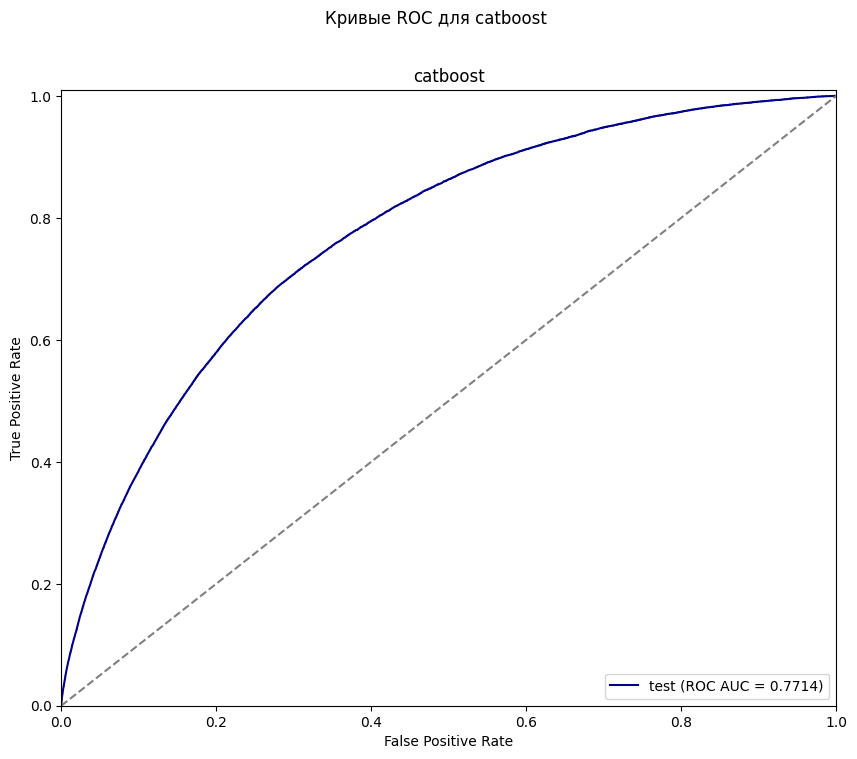

In [111]:
threshold = roc_plot('catboost')

In [109]:
predict = (proba > threshold).astype(int)
print(f'Best threshold = {threshold:.3f}\n')
print(f'Confusion matrix for the threshold = {threshold:.3f}:')
confusion_matrix(pred['flag'], predict)

Best threshold = 0.039

Confusion matrix for the threshold = 0.039:


array([[503670, 221591],
       [  7084,  17655]])

Итак, модель `catboost` даёт метрику ROC AUC = 0.7714

Пайплайн работает на данных в изначально заданном виде.